# Adjoint Method and Implicit Function Theorem: Introduction

This notebook provides a step-by-step explanation of the adjoint (reverse-mode) method and the implicit function theorem, as applied to differentiable algorithms involving root-finding and financial models.

## Motivation
In many computational finance problems, we need to compute derivatives (sensitivities) of outputs with respect to inputs, even when the computation involves solving equations implicitly. The adjoint method and implicit function theorem allow us to efficiently propagate derivatives through such algorithms, avoiding the need to differentiate through solvers directly.

## Structure
- Mathematical background and notation
- Decomposition of the algorithm
- Implicit differentiation
- Adjoint (reverse-mode) differentiation
- Example: Black-Scholes to Bachelier implied volatility mapping

Let's begin with the mathematical background and notation.

## Mathematical Background and Notation

Suppose we have a function $f: \mathbb{R}^{p_a} \to \mathbb{R}^{p_z}$, which is computed via an algorithm that involves solving an equation. The computation can be decomposed as follows:

- $b = g_1(a)$
- $c$ such that $g_2(b, c) = 0$ (root-finding problem)
- $z = g_3(c)$

where:
- $g_1: \mathbb{R}^{p_a} \to \mathbb{R}^{p_b}$
- $g_2: \mathbb{R}^{p_b} \times \mathbb{R}^{p_c} \to \mathbb{R}^{p_c}$
- $g_3: \mathbb{R}^{p_c} \to \mathbb{R}^{p_z}$

The second step involves finding $c$ such that $g_2(b, c) = 0$, which is a multi-dimensional root-finding problem. We assume all functions are differentiable.

The derivative of $f$ at $a$ is denoted $Df(a)$ or $D_a f(a)$, and is represented by a $p_z \times p_a$ matrix. Elements of $\mathbb{R}^p$ are column vectors.

In automatic differentiation (AD), we often have AD versions of $g_1$, $g_2$, and $g_3$, but not for the solver that computes $c$ from $b$. The implicit function theorem helps us differentiate through this solver efficiently.

Next, we'll see how the implicit function theorem applies to this setup.

## Explicit Expression for $f$ as a Composition

Given the decomposition:
- $b = g_1(a)$
- $c$ such that $g_2(b, c) = 0$
- $z = g_3(c)$

We can express $f$ as a composition of these functions, with $c$ defined implicitly:

$$
\begin{align*}
    f(a) &= g_3(c) \\
    \text{where } c &= g_4(b), \text{ and } b = g_1(a) \\
    \text{with } g_2(b, c) = 0
\end{align*}
$$

So, the overall mapping is:
$$
    f(a) = g_3(g_4(g_1(a)))
$$
where $g_4$ is the implicit function that solves $g_2(b, c) = 0$ for $c$ given $b$.

This composition highlights how the output $z$ depends on the input $a$ through a sequence of explicit and implicit steps.

## Implicit Function Theorem for Differentiation

When $c$ is defined implicitly by $g_2(b, c) = 0$, the implicit function theorem allows us to compute the derivative of $c$ with respect to $b$ without differentiating through the solver.

Let $g_4$ be the implicit function such that $c = g_4(b)$, i.e., $g_2(b, g_4(b)) = 0$.

The derivative of $g_4$ with respect to $b$ is:
$$
    D_b g_4(b) = -\left(D_c g_2(b, c)\right)^{-1} D_b g_2(b, c)
$$
where:
- $D_c g_2(b, c)$ is the Jacobian of $g_2$ with respect to $c$
- $D_b g_2(b, c)$ is the Jacobian of $g_2$ with respect to $b$

This formula allows us to propagate derivatives through the implicit step efficiently, using only the derivatives of $g_2$ (not the solver itself).

Next, we'll see how this fits into the overall adjoint (reverse-mode) differentiation process.

## Visual Representation: Scalar Case

The diagram below illustrates the flow of computations and derivatives for the scalar case ($a$, $b$, $c$, $z$ are all scalars). The arrows show the direction of computation and how sensitivities (derivatives) propagate backward.

If you do not have `graphviz` installed, run the first cell to install it.

In [1]:
# Install graphviz if needed
!pip install graphviz


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


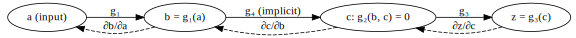

In [2]:
from graphviz import Digraph

# Create a directed graph
flow = Digraph(format='png')
flow.attr(rankdir='LR', size='8,4')

# Nodes for variables
flow.node('a', 'a (input)')
flow.node('b', 'b = g₁(a)')
flow.node('c', 'c: g₂(b, c) = 0')
flow.node('z', 'z = g₃(c)')

# Forward computation arrows
flow.edge('a', 'b', label='g₁')
flow.edge('b', 'c', label='g₄ (implicit)')
flow.edge('c', 'z', label='g₃')

# Backward (adjoint) arrows
flow.edge('z', 'c', label='∂z/∂c', style='dashed')
flow.edge('c', 'b', label='∂c/∂b', style='dashed')
flow.edge('b', 'a', label='∂b/∂a', style='dashed')

flow.render('scalar_adjoint_flow', view=True)
flow

## Adjoint (Reverse-Mode) Differentiation: Scalar Case

In the scalar case, the adjoint method propagates sensitivities (derivatives) backward through each step of the computation. The process is as follows:

Let $\bar{z}$ be the sensitivity of the output $z$ (usually set to 1 if $z$ is the final scalar output).

- $\bar{c} = \frac{\partial z}{\partial c} \cdot \bar{z}$
- $\bar{b} = \frac{\partial c}{\partial b} \cdot \bar{c}$
- $\bar{a} = \frac{\partial b}{\partial a} \cdot \bar{b}$

where:
- $\frac{\partial c}{\partial b}$ is computed using the implicit function theorem:
  $$
  \frac{\partial c}{\partial b} = -\frac{\partial g_2}{\partial b} \Big/ \frac{\partial g_2}{\partial c}
  $$

This chain of derivatives gives the total sensitivity of the output with respect to the input, efficiently propagating through both explicit and implicit steps.

## Relating Adjoint Steps to the Derivative of $f$ with Respect to $a$

The goal is to compute the total derivative $\frac{df}{da}$, where $f(a) = g_3(c)$ and $c$ is implicitly defined by $g_2(b, c) = 0$ with $b = g_1(a)$.

Using the chain rule and the adjoint steps:

- $\frac{df}{da} = \frac{dz}{da}$
- $\frac{dz}{da} = \frac{dz}{dc} \cdot \frac{dc}{db} \cdot \frac{db}{da}$

where:
- $\frac{dz}{dc} = g_3'(c)$
- $\frac{db}{da} = g_1'(a)$
- $\frac{dc}{db} = -\frac{\partial g_2}{\partial b} \Big/ \frac{\partial g_2}{\partial c}$ (from the implicit function theorem)

So, the total derivative is:
$$
\frac{df}{da} = g_3'(c) \cdot \left(-\frac{\partial g_2}{\partial b} \Big/ \frac{\partial g_2}{\partial c}\right) \cdot g_1'(a)
$$

This shows how the adjoint steps correspond directly to the chain of derivatives needed to compute $\frac{df}{da}$, efficiently propagating sensitivities through both explicit and implicit parts of the computation.

## Key Insight: Implicit Derivative from Explicit Derivatives

**Main Point:**

The derivative of the implicit function $g_4$ (which gives $c$ as a function of $b$) does not require differentiating through the solver. Instead, it can be computed directly from the explicit partial derivatives of $g_2$:

$$
\frac{dc}{db} = -\frac{\partial g_2}{\partial b} \Big/ \frac{\partial g_2}{\partial c}
$$

This means:
- You do **not** need to differentiate the algorithm that solves $g_2(b, c) = 0$ for $c$.
- You only need the explicit formulas for $\frac{\partial g_2}{\partial b}$ and $\frac{\partial g_2}{\partial c}$.

This is the power of the implicit function theorem in adjoint differentiation: it turns an implicit step into a formula involving only explicit derivatives.

## Step-by-Step Summary of the Adjoint Implicit Differentiation Process

Here is a clear summary of the steps involved:

1. **Compute $b$ from $a$:**
   - $b = g_1(a)$
2. **Solve for $c$ implicitly:**
   - Find $c$ such that $g_2(b, c) = 0$
   - This usually requires a numerical root-finding algorithm
3. **Compute $z$ from $c$:**
   - $z = g_3(c)$
4. **Calculate explicit derivatives:**
   - $g_1'(a)$, $g_3'(c)$, $\frac{\partial g_2}{\partial b}$, $\frac{\partial g_2}{\partial c}$
5. **Apply the implicit function theorem:**
   - $\frac{dc}{db} = -\frac{\partial g_2}{\partial b} \Big/ \frac{\partial g_2}{\partial c}$
6. **Chain the derivatives to get $\frac{dz}{da}$:**
   - $\frac{dz}{da} = g_3'(c) \cdot \frac{dc}{db} \cdot g_1'(a)$

Next, we'll walk through a concrete code example to illustrate each step.

## Example: Explicit Adjoint Steps for Simple Functions

Let's choose simple scalar functions for illustration:
- $g_1(a) = 2a$
- $g_2(b, c) = c^2 + b - 4$ (solve for $c$ given $b$)
- $g_3(c) = \sin(c)$

We'll walk through each step, solve for $c$, compute all required derivatives, and use the implicit function theorem to find $\frac{dz}{da}$ explicitly.

In [3]:
import numpy as np
from scipy.optimize import root_scalar

# Step 1: Compute b from a
def g1(a):
    return 2 * a

# Step 2: Solve for c such that g2(b, c) = 0
def g2(b, c):
    return c**2 + b - 4

# Step 3: Compute z from c
def g3(c):
    return np.sin(c)

a = 1.0  # Example input
b = g1(a)

# Find a bracket where g2(b, c) changes sign
print(f"g2(b, -2) = {g2(b, -2)}")
print(f"g2(b, 0) = {g2(b, 0)}")
# Solve g2(b, c) = 0 for c (find root)
sol = root_scalar(lambda c: g2(b, c), bracket=[-2, 0])
c = sol.root
z = g3(c)

# Step 4: Compute explicit derivatives
g1_prime = 2
# For g2: partial derivatives at (b, c)
dg2_db = 1
# dg2/dc = 2c
# For g3: derivative at c
g3_prime = np.cos(c)
dg2_dc = 2 * c

# Step 5: Implicit function theorem
dc_db = -dg2_db / dg2_dc

# Step 6: Chain the derivatives
dz_da = g3_prime * dc_db * g1_prime

print(f"a = {a}")
print(f"b = g1(a) = {b}")
print(f"c (solved) = {c}")
print(f"z = g3(c) = {z}")
print(f"g1'(a) = {g1_prime}")
print(f"dg2/db = {dg2_db}")
print(f"dg2/dc = {dg2_dc}")
print(f"g3'(c) = {g3_prime}")
print(f"dc/db (implicit) = {dc_db}")
print(f"dz/da (total derivative) = {dz_da}")

g2(b, -2) = 2.0
g2(b, 0) = -2.0
a = 1.0
b = g1(a) = 2.0
c (solved) = -1.4142135623730951
z = g3(c) = -0.9877659459927356
g1'(a) = 2
dg2/db = 1
dg2/dc = -2.8284271247461903
g3'(c) = 0.15594369476537437
dc/db (implicit) = 0.35355339059327373
dz/da (total derivative) = 0.11026884405188132


Error: no "view" mailcap rules found for type "image/png"
Try running the update-desktop-database command. If you
don't have this command you should install the
desktop-file-utils package. This package is available from
http://freedesktop.org/wiki/Software/desktop-file-utils/
No applications found for mimetype: image/png
.

## Automatic Differentiation (AD) Approach for the Same Example

Let's use the same functions and compute the total derivative $dz/da$ using automatic differentiation (AD) with the `autograd` library. This will differentiate through the solver, which is less efficient and less transparent than the implicit method, but useful for comparison.

In [ ]:
import autograd.numpy as anp
from autograd import grad
from scipy.optimize import root_scalar

# Define the full computation as a function of a
def full_process(a):
    b = 2 * a
    # Solve for c numerically using autograd-compatible numpy
    def g2_c(c):
        return c**2 + b - 4
    sol = root_scalar(g2_c, bracket=[-2, 0], method='bisect')
    c = sol.root
    z = anp.sin(c)
    return z

# Compute dz/da using autograd
dz_da_ad = grad(full_process)
a_val = 1.0
z_val = full_process(a_val)
deriv_val = dz_da_ad(a_val)

print(f"AD approach:")
print(f"a = {a_val}")
print(f"z = {z_val}")
print(f"dz/da (AD) = {deriv_val}")

/usr/bin/xdg-open: 882: x-www-browser: not found


ModuleNotFoundError: No module named 'autograd'

/usr/bin/xdg-open: 882: firefox: not found
/usr/bin/xdg-open: 882: iceweasel: not found
/usr/bin/xdg-open: 882: iceweasel: not found
/usr/bin/xdg-open: 882: seamonkey: not found
/usr/bin/xdg-open: 882: seamonkey: not found
/usr/bin/xdg-open: 882: mozilla: not found
/usr/bin/xdg-open: 882: mozilla: not found
/usr/bin/xdg-open: 882: epiphany: not found
/usr/bin/xdg-open: 882: epiphany: not found
/usr/bin/xdg-open: 882: konqueror: not found
/usr/bin/xdg-open: 882: konqueror: not found
/usr/bin/xdg-open: 882: chromium: not found
/usr/bin/xdg-open: 882: chromium: not found
/usr/bin/xdg-open: 882: chromium-browser: not found
/usr/bin/xdg-open: 882: chromium-browser: not found
/usr/bin/xdg-open: 882: google-chrome: not found
/usr/bin/xdg-open: 882: google-chrome: not found
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/us